In [92]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns
pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning

from functools import reduce

In [93]:
#reading Dataset
retail = pd.read_csv("Online Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)

In [94]:
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [95]:
retail.shape

(541909, 8)

#### Remove rows where CustomerID is NA

In [97]:
retail.dropna(inplace=True)
retail.shape

(406829, 8)

Our main objective is to cluster the customers of the online store. So, we need to transform this order-wise data into customer-wise data by finding key attributes that best characterises a customer. This is achieved through RFM analysis.

__RFM analysis__

In RFM analysis, we look at the recency, frequency and the monetary scores of all the customers for segmentation.

__Recency__: It measures how recently you visited the store or made a purchase

__Frequency__: It measures the frequency of the transactions the customers made

__Monetary__: It measures how much the customer spent on purchases he/she made

So, our target is to compute the RFM numbers for each customer, which effectively means that the granularity level of your data set will change from Invoice number to the CustomerID. Thus, we will have one unique row corresponding to each customer.

### Recency

In [165]:
R = retail[['CustomerID','InvoiceDate']]
maxInvoiceDate = max(R['InvoiceDate'])+ pd.DateOffset(days=1)
R['Recency'] = (maxInvoiceDate - R['InvoiceDate']).dt.days
R = R.groupby(by ='CustomerID')['Recency'].min().reset_index()
R.head()

,CustomerID,Recency
0,12346.0,327
1,12347.0,41
2,12348.0,77
3,12349.0,20
4,12350.0,312


### Frequency

In [166]:
F = retail.groupby(by = 'CustomerID')[['InvoiceNo']].count().reset_index()
F.columns = ["CustomerID", "Frequency"]
F.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


### Monetary

In [167]:
M = retail[['CustomerID','UnitPrice','Quantity']]
M['Monetary'] = M['UnitPrice'] * M['Quantity']
M = M.groupby(by = 'CustomerID')[['Monetary']].sum().reset_index()
M.head()

,CustomerID,Monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [168]:
dfs = [R,F,M]
RFM = reduce(lambda left,right: pd.merge(left,right,on='CustomerID'), dfs)
RFM.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,327,2,0.00
1,12347.0,41,182,4310.00
2,12348.0,77,31,1797.24
3,12349.0,20,73,1757.55
4,12350.0,312,17,334.40


### Feature Scaling

In [170]:
X = RFM.drop("CustomerID", axis=1)

In [106]:
# standardise all parameters

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(X)
X = pd.DataFrame(scaled, index=X.index, columns=X.columns)

In [113]:
X.head()

,Recency,Frequency,Monetary
0,1.975600,-0.391720,-0.231001
1,-0.535025,0.382657,0.293432
2,-0.219002,-0.266959,-0.012316
3,-0.719372,-0.086271,-0.017146
4,1.843924,-0.327188,-0.190312


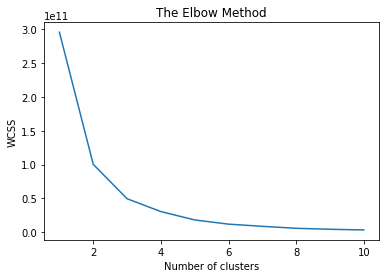

In [171]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 27)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [172]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 5, init = 'k-means++',max_iter = 100, random_state = 27)
y_kmeans = kmeans.fit_predict(X)

In [173]:
cluster = pd.DataFrame(y_kmeans)
cluster.columns = ['Cluster']

In [174]:
RFM_Clustered = pd.concat(objs=[RFM,cluster],axis=1)
RFM_Clustered.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,327,2,0.00,0
1,12347.0,41,182,4310.00,0
2,12348.0,77,31,1797.24,0
3,12349.0,20,73,1757.55,0
4,12350.0,312,17,334.40,0


In [175]:
RFM_Clustered['Cluster'].value_counts()

0    4070
4     268
2      27
1       5
3       2
Name: Cluster, dtype: int64

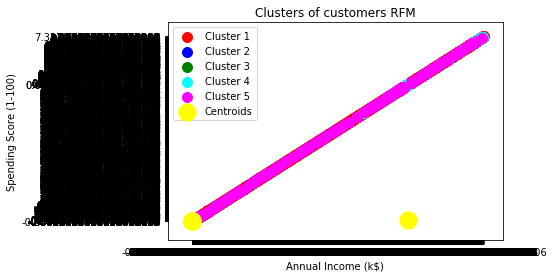

In [134]:
# Visualising the clusters
plt.scatter(X[y_kmeans == 0], X[y_kmeans == 0], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1], X[y_kmeans == 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2], X[y_kmeans == 2], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_kmeans == 3], X[y_kmeans == 3], s = 100, c = 'cyan', label = 'Cluster 4')
plt.scatter(X[y_kmeans == 4], X[y_kmeans == 4], s = 100, c = 'magenta', label = 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers RFM')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()